In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV


warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
df.shape

(7043, 21)

## Preprocessing

In [7]:
df['TotalCharges'] = df['TotalCharges'].apply(pd.to_numeric, errors='coerce')
df['TotalCharges'].dtype

dtype('float64')

In [8]:
df['TotalCharges'].isnull().sum()

11

In [9]:
df['TotalCharges'] = df['TotalCharges'].fillna(value=0)
df['TotalCharges'].isnull().sum()

0

In [10]:
def apply_yes_no(df, column_name):
    df[column_name] = df[column_name].replace({"No": 0, "Yes": 1})
    return df

In [11]:
apply_yes_no(df, 'Churn')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [12]:
X = df.drop(columns = 'Churn')
y = df['Churn']

In [13]:
categorical_col = X[['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','Contract', 'PaperlessBilling', 'PaymentMethod']]

numerical_col = X[['tenure', 'MonthlyCharges', 'TotalCharges']]

## Feature Engineering

In [14]:
scaler = StandardScaler()
num = scaler.fit(numerical_col)
num = scaler.transform(numerical_col)
num = pd.DataFrame(data=num)
num

,0,1,2
0,-1.277445,-1.160323,-0.992611
1,0.066327,-0.259629,-0.172165
2,-1.236724,-0.362660,-0.958066
3,0.514251,-0.746535,-0.193672
4,-1.236724,0.197365,-0.938874
...,...,...,...
7038,-0.340876,0.665992,-0.127605
7039,1.613701,1.277533,2.242606
7040,-0.870241,-1.168632,-0.852932
7041,-1.155283,0.320338,-0.870513


In [15]:
num.columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
num.head()

,tenure,MonthlyCharges,TotalCharges
0,-1.277445,-1.160323,-0.992611
1,0.066327,-0.259629,-0.172165
2,-1.236724,-0.362660,-0.958066
3,0.514251,-0.746535,-0.193672
4,-1.236724,0.197365,-0.938874


In [16]:
encoder = OneHotEncoder(sparse_output=False)
cat = encoder.fit_transform(categorical_col)
encoder.get_feature_names_out()

array(['gender_Female', 'gender_Male', 'SeniorCitizen_0',
       'SeniorCitizen_1', 'Partner_No', 'Partner_Yes', 'Dependents_No',
       'Dependents_Yes', 'PhoneService_No', 'PhoneService_Yes',
       'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service',
       'StreamingTV_Yes', 'StreamingMovies_No',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling

In [17]:
cat = pd.DataFrame(data=cat)
cat.columns = ['gender_Female', 'gender_Male', 'SeniorCitizen_0',
       'SeniorCitizen_1', 'Partner_No', 'Partner_Yes', 'Dependents_No',
       'Dependents_Yes', 'PhoneService_No', 'PhoneService_Yes',
       'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service',
       'StreamingTV_Yes', 'StreamingMovies_No',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_No', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']
cat.head()

,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [18]:
X = pd.concat([num, cat], axis=1)
X.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.277445,-1.160323,-0.992611,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.066327,-0.259629,-0.172165,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-1.236724,-0.362660,-0.958066,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.514251,-0.746535,-0.193672,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,-1.236724,0.197365,-0.938874,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
X,
y,
test_size = 0.2,
random_state = 1)

# Model Building

In [20]:
rf_model = RandomForestClassifier(random_state=1)
ex_model = ExtraTreesClassifier(random_state=1)
xgb_model = XGBClassifier(random_state=1)
lgbm_model = LGBMClassifier(random_state=1)

## RandomForestClassifier Model Training and Evaluation

In [21]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [22]:
rf_pred = rf_model.predict(X_test)
rf_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

#### F1-Score Eval

In [23]:
f1_rf = f1_score(y_true=y_test, y_pred=rf_pred, pos_label=1)
print('F1: {}'.format(round(f1_rf*100), 2))

F1: 56


#### Accuracy Score Eval

In [24]:
acc_rf = accuracy_score(y_true=y_test, y_pred=rf_pred)
print('Accuracy: {}'.format(round(acc_rf*100), 2))

Accuracy: 79


#### Recall Score Eval

In [25]:
recall_rf = recall_score(y_true=y_test, y_pred=rf_pred, pos_label=1)
print('Recall: {}'.format(round(recall_rf*100), 2))

Recall: 53


#### Precision Score Eval

In [26]:
precision_rf = precision_score(y_true=y_test, y_pred=rf_pred, pos_label=1)
print('Precision: {}'.format(round(precision_rf*100), 2))


Precision: 58


#### Cross validation Score

In [27]:
cvscores_rf = cross_val_score(rf_model, X_test, y_test, cv=5, scoring='f1_macro')
average_score_rf = round((cvscores_rf.mean() * 100),0)
average_score_rf

70.0

#### ConfusionMatrix Eval

In [28]:
cnf_mat = confusion_matrix(y_true=y_test, y_pred=rf_pred, labels=[0, 1])
cnf_mat

array([[929, 132],
       [163, 185]], dtype=int64)

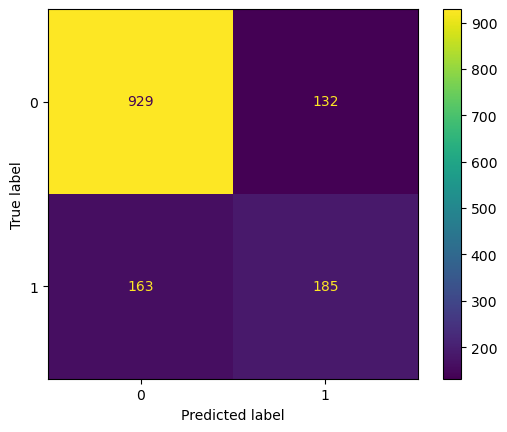

In [29]:
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test);

## ExtraTreesClassifier Model Training and Evaluation

In [30]:
ex_model.fit(X_train, y_train)

ExtraTreesClassifier(random_state=1)

In [31]:
ex_pred = ex_model.predict(X_test)
ex_pred

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

#### F1-Score Eval

In [32]:
f1_ex = f1_score(y_true=y_test, y_pred=ex_pred, pos_label=1)
print('F1: {}'.format(round(f1_ex*100), 2))


F1: 51


#### Accuracy Score Eval

In [33]:
acc_ex = accuracy_score(y_true=y_test, y_pred=ex_pred)
print('Accuracy: {}'.format(round(acc_ex*100), 2))


Accuracy: 77


#### Recall Score Eval

In [34]:
recall_ex = recall_score(y_true=y_test, y_pred=ex_pred, pos_label=1)
print('Recall: {}'.format(round(recall_ex*100), 2))


Recall: 48


#### Precision Score Eval

In [35]:
precision_ex = precision_score(y_true=y_test, y_pred=ex_pred, pos_label=1)
print('Precision: {}'.format(round(precision_ex*100), 2))

Precision: 54


#### Cross validation Score

In [36]:
cvscores_ex = cross_val_score(ex_model, X_test, y_test, cv=5, scoring='f1_macro')
average_score_ex = round((cvscores_ex.mean() * 100),0)
average_score_ex

67.0

#### ConfusionMatrix Eval

In [37]:
cnf_mat = confusion_matrix(y_true=y_test, y_pred=ex_pred, labels=[0, 1])
cnf_mat

array([[917, 144],
       [180, 168]], dtype=int64)

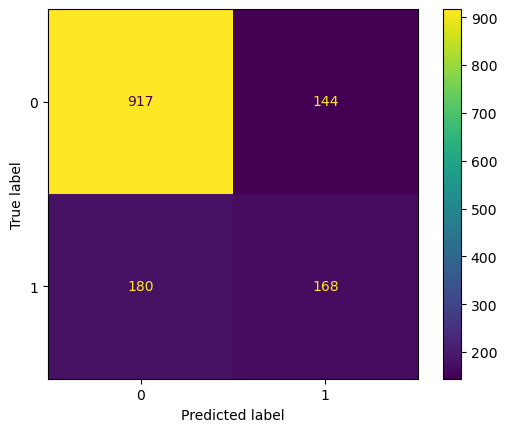

In [38]:
ConfusionMatrixDisplay.from_estimator(ex_model, X_test, y_test);

#### Hyperparameter tuning for ExtraTreesClassifier

In [62]:
n_estimators = [50, 100, 300, 500, 1000]

min_samples_split = [2, 3, 5, 7, 9]

min_samples_leaf = [1, 2, 4, 6, 8]

max_features = ['auto', 'sqrt', 'log2', None] 

hyperparameter_grid = {'n_estimators': n_estimators,

                       'min_samples_leaf': min_samples_leaf,

                       'min_samples_split': min_samples_split,

                       'max_features': max_features}

xt_model = ExtraTreesClassifier(random_state=1)

clf = GridSearchCV(xt_model,
                   hyperparameter_grid,
                   cv=5,
                   scoring = 'accuracy',
                   n_jobs = -1,
                   verbose = 1 
)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


GridSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4, 6, 8],
                         'min_samples_split': [2, 3, 5, 7, 9],
                         'n_estimators': [50, 100, 300, 500, 1000]},
             scoring='accuracy', verbose=1)

In [63]:
clf.best_params_

{'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_estimators': 100}

In [65]:
clf_pred = clf.predict(X_test)
clf_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [66]:
acc_clf = accuracy_score(y_true=y_test, y_pred=clf_pred)
print('Accuracy: {}'.format(round(acc_ex*100), 2))

Accuracy: 77


## XGBoostClassifier Model Training and Evaluation

In [40]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [41]:
xgb_pred = xgb_model.predict(X_test)
xgb_pred

array([0, 0, 0, ..., 0, 0, 1])

#### F1-Score Eval

In [42]:
f1_xgb = f1_score(y_true=y_test, y_pred=xgb_pred, pos_label=1)
print('F1: {}'.format(round(f1_xgb*100), 2))


F1: 57


#### Accuracy Score Eval

In [43]:
acc_xgb = accuracy_score(y_true=y_test, y_pred=xgb_pred)
print('Accuracy: {}'.format(round(acc_xgb*100), 2))


Accuracy: 79


#### Recall Score Eval

In [44]:
recall_xgb = recall_score(y_true=y_test, y_pred=xgb_pred, pos_label=1)
print('Recall: {}'.format(round(recall_xgb*100), 2))


Recall: 56


#### Precision Score Eval

In [45]:
precision_xgb = precision_score(y_true=y_test, y_pred=xgb_pred, pos_label=1)
print('Precision: {}'.format(round(precision_xgb*100), 2))


Precision: 59


#### Cross validation Score

In [46]:
cvscores_xgb = cross_val_score(xgb_model, X_test, y_test, cv=5, scoring='f1_macro')
average_score_xgb = round((cvscores_xgb.mean() * 100),0)
average_score_xgb

69.0

#### ConfusionMatrix Eval

In [47]:
cnf_mat = confusion_matrix(y_true=y_test, y_pred=xgb_pred, labels=[0, 1])
cnf_mat

array([[924, 137],
       [154, 194]], dtype=int64)

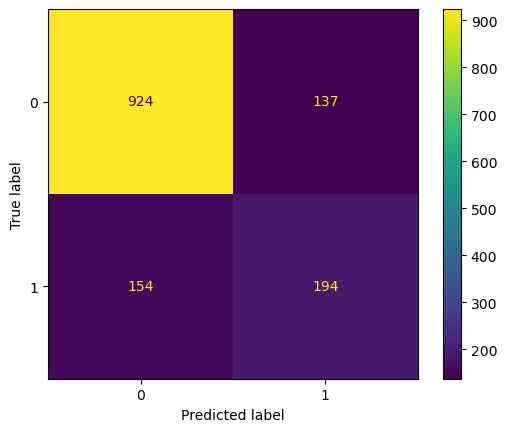

In [48]:
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test);

## LGBMClassifier Model Training and Evaluation

In [49]:
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1521, number of negative: 4113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 670
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.269968 -> initscore=-0.994785
[LightGBM] [Info] Start training from score -0.994785


LGBMClassifier(random_state=1)

In [50]:
lgbm_pred = lgbm_model.predict(X_test)
lgbm_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

#### F1-Score Eval

In [51]:
f1_lgbm = f1_score(y_true=y_test, y_pred=lgbm_pred, pos_label=1)
print('F1: {}'.format(round(f1_lgbm*100), 2))

F1: 61


#### Accuracy Score Eval

In [52]:
acc_lgbm = accuracy_score(y_true=y_test, y_pred=lgbm_pred)
print('Accuracy: {}'.format(round(acc_lgbm*100), 2))

Accuracy: 81


#### Recall Score Eval

In [53]:
recall_lgbm = recall_score(y_true=y_test, y_pred=lgbm_pred, pos_label=1)
print('Recall: {}'.format(round(recall_lgbm*100), 2))

Recall: 59


#### Precision Score Eval

In [54]:
precision_lgbm = precision_score(y_true=y_test, y_pred=lgbm_pred, pos_label=1)
print('Precision: {}'.format(round(precision_lgbm*100), 2))

Precision: 63


#### Cross validation Score

In [55]:
cvscores_lgbm = cross_val_score(lgbm_model, X_test, y_test, cv=5, scoring='f1_macro')
average_score_lgbm = round((cvscores_lgbm.mean() * 100),0)
average_score_lgbm

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 279, number of negative: 848
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 1127, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247560 -> initscore=-1.111669
[LightGBM] [Info] Start training from score -1.111669


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 278, number of negative: 849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 670
[LightGBM] [Info] Number of data points in the train set: 1127, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.246673 -> initscore=-1.116438
[LightGBM] [Info] Start training from score -1.116438
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 278, number of negative: 849
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number o

69.0

#### ConfusionMatrix Eval

In [56]:
cnf_mat = confusion_matrix(y_true=y_test, y_pred=lgbm_pred, labels=[0, 1])
cnf_mat

array([[940, 121],
       [142, 206]], dtype=int64)

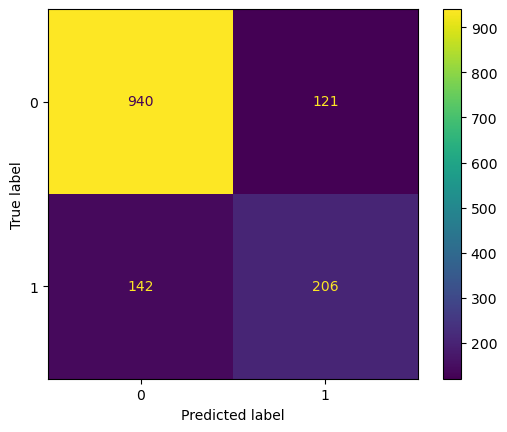

In [57]:
ConfusionMatrixDisplay.from_estimator(lgbm_model, X_test, y_test);

## General Model Evaluation

In [58]:
models = pd.DataFrame({
    'Model' : ['RandomForestClassifier','ExtraTreesClassifier', 'XGBoostClassifier', 'LGBMClassifier'],
    'F1-Score' : [f1_rf, f1_ex, f1_xgb,f1_lgbm],
    'Accuracy-Score' : [acc_rf, acc_ex, acc_xgb, acc_lgbm],
    'Recall-Score' : [recall_rf, recall_ex, recall_xgb, recall_lgbm],
    'Precision-score' : [precision_rf, precision_ex, precision_xgb, precision_lgbm],
    'CrossVal-Score' : [average_score_rf, average_score_ex, average_score_xgb, average_score_lgbm]
})
models

,Model,F1-Score,Accuracy-Score,Recall-Score,Precision-score,CrossVal-Score
0,RandomForestClassifier,0.556391,0.790632,0.531609,0.583596,70.0
1,ExtraTreesClassifier,0.509091,0.770050,0.482759,0.538462,67.0
2,XGBoostClassifier,0.571429,0.793471,0.557471,0.586103,69.0
3,LGBMClassifier,0.610370,0.813343,0.591954,0.629969,69.0


In [59]:
F1_model = models.sort_values(by = 'F1-Score', ascending = True)

In [60]:
for i in models.columns[1:]:
    Model = models.sort_values(by = i, ascending = True)
    fig = px.bar(data_frame = Model, x =i , y = 'Model', color = i, template = 'plotly_dark', title =(f'{i} Models Comparison'))
    fig.show()